In [1]:
import os, sys, random, math, time
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
sys.path.append('../../neural-sketch/src/')
sys.path.append('../../neural-sketch/')
sys.path.append('../../')
sys.path.append('../../../')
from src.models.frequency.countsketch import CountSketchQueryNetwork
from src.models.frequency.countmin import CountMinSketchQueryNetwork
from src.models.networks.sqnet import SketchNetwork, QueryNetworkTask
from src.models.networks.layers.residual import ResidualFC, ResidualFCwithPermute, ResidualFCLN
from src.models.networks.layers.permute import Permute
from src.datasets.zipf import get_zipf_probs, get_dataset_samples, ZipfOnlineDatasetLoader

In [2]:
class MeanDim(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        return torch.mean(x, dim=self.dim)
    

class ResNetMLPLN(torch.nn.Module):

    def __init__(self, in_dim, out_dim, hidden_dim=None, bottleneck_dim=None,num_layers=3, input_bn=False, output_bn=False):
        super().__init__()
        
        if hidden_dim == None:
            hidden_dim = in_dim*2
        residual_layers = [ResidualFCLN(hidden_dim, bottleneck_dim=bottleneck_dim) for _ in range(num_layers)]
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            *residual_layers,
            nn.Linear(hidden_dim, out_dim),
        )        
                
    def forward(self, x):
        y = self.net(x)
        return y

In [3]:

device = 'cpu'
datasets_path = ''
datasets_list = ['MNIST','fashion_MNIST','humans','dogs','KDD','heart','QuickDraw10','adults','bank']
        
def read_data(path):
    # Read data
    try:
        data = np.load(path)
        data_train = torch.from_numpy(data['train']).float()
        data_val = torch.from_numpy(data['val']).float()
        data_test = torch.from_numpy(data['test']).float()
    except:
        print('Error in reading data or data does not have the required fields. Inside the compressed file .npz it must be 3 numpy arrays with the following names: train, testa, and val')
        sys.exit(1)

    return data_train,data_val,data_test


In [4]:
with_mean = False
with_rf = False
with_sketch = False

sketch_size = 50
N_DIMS = 1000
SN = ResNetMLPLN(N_DIMS, sketch_size, hidden_dim=4096, bottleneck_dim=4096, num_layers=5, output_bn=True).to(device)
QN = ResNetMLPLN(sketch_size, N_DIMS, hidden_dim=4096, bottleneck_dim=4096, num_layers=5, input_bn=True).to(device)
sketch_net= None
RF = None
dataset_name = 'bank'
sn_path = ''
qn_path = ''



In [5]:
# load network

with_mean = True
with_rf = False
with_sketch = True
rf_ratio=4
sketch_ratio=5
sketch_size = 50
N_DIMS = 1000
SN = ResNetMLPLN(N_DIMS+N_DIMS+N_DIMS*sketch_ratio, sketch_size, hidden_dim=4096, bottleneck_dim=4096, num_layers=5, output_bn=True).to(device)
QN = ResNetMLPLN(sketch_size+N_DIMS+N_DIMS*sketch_ratio, N_DIMS, hidden_dim=4096, bottleneck_dim=4096, num_layers=5, input_bn=True).to(device)
RF = nn.Sequential(*[nn.Linear(N_DIMS,int(N_DIMS*rf_ratio)),nn.ReLU()]).to(device)
sketch_net = nn.Sequential(*[ResNetMLPLN(N_DIMS, N_DIMS*sketch_ratio, hidden_dim=4096, bottleneck_dim=4096, num_layers=3), MeanDim(1)]).to(device)
sn_path = ''
qn_path = ''
rf_path = ''
sketch_path = ''



SN.load_state_dict(torch.load(sn_path, map_location=device))
QN.load_state_dict( torch.load(qn_path, map_location=device))

models = [SN, QN]

if with_rf:
    RF.load_state_dict( torch.load(rf_path, map_location=device))
    models.append(RF)
    RF.eval()

if with_sketch:
    sketch_net.load_state_dict( torch.load(sketch_path, map_location=device))
    models.append(sketch_net)
    sketch_net.eval()
    
SN.eval()
QN.eval()


for model in models:
    model.eval()
    for name ,child in (model.named_children()):
        child.eval()
        for param in child.parameters():
            param.requires_grad = False

print('network loaded')

network loaded


In [6]:
from sklearn.cluster import KMeans

kmeans_sketch = False
randomly_subsample = False

num_mem_samples = -1

def eval_network(SN,QN,sketch_net,RF,data_train, data_val,data_test, verbose=True):
    img_eval = data_test
    y_ = img_eval
    
    mem = torch.cat([data_train, data_val], dim=0)
    
    if randomly_subsample:
        idx = torch.randperm(mem.shape[0])
        mem = mem[idx,:]
        mem = mem[0:num_mem_samples,:]
        
    bal_acc_kmeans = torch.tensor(0.0)
    if kmeans_sketch:
        K = 10
        kmeans = KMeans(n_clusters=K, random_state=0).fit(mem.cpu().numpy())
        print('fitting kmeans...')
        mem_kmeans = kmeans.predict(mem.cpu().numpy())
        mem_kmeans = torch.tensor(mem_kmeans).long()

        valid_K = torch.unique(mem_kmeans)
        means = []
        sketches = []
        for k in valid_K:

            mem_ = mem[mem_kmeans==k,:]

            m = torch.mean(mem_, dim=0).unsqueeze(0)
            s = sketch_net(mem_.unsqueeze(0))

            means.append(m)
            sketches.append(s)
        sketch = torch.cat(sketches)
        mean = torch.cat(means)

        y_kmeans = torch.tensor(kmeans.predict(y_.cpu().numpy())).long()
        centroids = torch.tensor(kmeans.cluster_centers_).float()
        y_rec = (centroids[y_kmeans,:] > 0.5).float()
        bal_acc_kmeans =1 - (0.5*torch.mean(torch.abs(y_rec[img_eval==0])) + 0.5*torch.mean(torch.abs(y_rec[img_eval==1]-1)))
        print('KMEANS BAL ACC IS, ', bal_acc_kmeans)


        mean = mean[y_kmeans,:].to(device)
        sketch = sketch[y_kmeans,:].to(device)

    else:
        if with_mean:
            mean = torch.mean(mem, dim=0).repeat(img_eval.shape[0],1).to(device)
        if with_rf:
            rf = torch.mean(RF(mem),dim=0).repeat(img_eval.shape[0],1)
        if with_sketch:
            sketch = sketch_net(mem[:,:].unsqueeze(0).to(device)).to(device).repeat(img_eval.shape[0],1)


    
    if with_mean:
        y_ = torch.cat([y_,mean], dim=1)
    if with_rf:
        y_ = torch.cat([y_,rf], dim=1)
    if with_sketch:
        y_ = torch.cat([y_,sketch], dim=1)


    z = SN(y_)


    if with_mean:
        z = torch.cat([z,mean], dim=1)
    if with_rf:
        z = torch.cat([z,rf], dim=1)
    if with_sketch: 
        z = torch.cat([z,sketch], dim=1)

    y_hat = torch.sigmoid(QN(z)).squeeze().float()
    y_hat_t = (y_hat > 0.5).float()
    error_total = torch.mean(torch.square(y_hat-img_eval))
    error_total_threshold = torch.mean(torch.square(y_hat_t-img_eval))
    acc = 1 - (0.5*torch.mean(torch.abs(y_hat_t[img_eval==0])) + 0.5*torch.mean(torch.abs(y_hat_t[img_eval==1]-1)))

    #print(acc.shape)
    if verbose:
        print('Total error is', error_total.item())
        print('Total error threshold is', error_total_threshold.item())
        print('Total bal acc is', acc.item())
    return error_total.item(), error_total_threshold.item(), acc.item(), bal_acc_kmeans.item()


avg_error = []
avg_bal_acc = []
kmean_bal_acc = []
for dataset in datasets_list:
    print('\nDataset is....', dataset)
    path = datasets_path + dataset + '.npz'
    data_train, data_val, data_test = read_data(path)


    err, err_t, acc, kmean_acc = eval_network(SN,QN,sketch_net,None,data_train, data_val,data_test)
    avg_error.append(err_t)
    avg_bal_acc.append(acc)
    kmean_bal_acc.append(kmean_acc)
    
print('\n\nDone!!')
print('Mean error is: ', np.mean(avg_error))
print('Mean bal acc is: ', np.mean(avg_bal_acc))
print('kmeans Mean bal acc is: ', np.mean(kmean_bal_acc))

str_acc = ''
for acc in avg_bal_acc:
    str_acc += '{:.1f} & '.format(acc*100)
str_acc += '{:.1f}'.format(np.mean(avg_bal_acc)*100)    
print(str_acc)


Dataset is.... MNIST
Total error is 0.0403582826256752
Total error threshold is 0.058282334357500076
Total bal acc is 0.8013623356819153

Dataset is.... fashion_MNIST
Total error is 0.11392460018396378
Total error threshold is 0.1518254280090332
Total bal acc is 0.7708661556243896

Dataset is.... humans
Total error is 0.05426723510026932
Total error threshold is 0.07700240612030029
Total bal acc is 0.8161379098892212

Dataset is.... dogs
Total error is 0.20371216535568237
Total error threshold is 0.2692500054836273
Total bal acc is 0.6888409852981567

Dataset is.... KDD
Total error is 0.13727381825447083
Total error threshold is 0.17272531986236572
Total bal acc is 0.7281631231307983

Dataset is.... heart
Total error is 0.018964966759085655
Total error threshold is 0.0224520955234766
Total bal acc is 0.7905546426773071

Dataset is.... QuickDraw10
Total error is 0.05295654386281967
Total error threshold is 0.07158640027046204
Total bal acc is 0.6350519061088562

Dataset is.... adults
T

In [7]:
# 

In [8]:
list_of_list = []
for _ in range(4):
    all_error_list = []

    randomly_subsample = True

    for num_mem_samples in [1,5,10,50,100,1000,-1]:


        avg_error = []
        avg_bal_acc = []
        kmean_bal_acc = []
        for dataset in datasets_list:
            print('\nDataset is....', dataset)
            path = datasets_path + dataset + '.npz'
            data_train, data_val, data_test = read_data(path)

            err, err_t, acc, kmean_acc = eval_network(SN,QN,sketch_net,None,data_train, data_val,data_test, verbose=False)
            avg_error.append(err_t)
            avg_bal_acc.append(acc)
            kmean_bal_acc.append(kmean_acc)


        print('Mean bal acc is: ', np.mean(avg_bal_acc))
        all_error_list.append(np.mean(avg_bal_acc))
        print('List is ', all_error_list)
    
    list_of_list.append(np.array(all_error_list))


Dataset is.... MNIST

Dataset is.... fashion_MNIST

Dataset is.... humans

Dataset is.... dogs

Dataset is.... KDD

Dataset is.... heart

Dataset is.... QuickDraw10

Dataset is.... adults

Dataset is.... bank
Mean bal acc is:  0.6513578626844618
List is  [0.6513578626844618]

Dataset is.... MNIST

Dataset is.... fashion_MNIST

Dataset is.... humans

Dataset is.... dogs

Dataset is.... KDD

Dataset is.... heart

Dataset is.... QuickDraw10

Dataset is.... adults

Dataset is.... bank
Mean bal acc is:  0.7107077770762973
List is  [0.6513578626844618, 0.7107077770762973]

Dataset is.... MNIST

Dataset is.... fashion_MNIST

Dataset is.... humans

Dataset is.... dogs

Dataset is.... KDD

Dataset is.... heart

Dataset is.... QuickDraw10

Dataset is.... adults

Dataset is.... bank
Mean bal acc is:  0.7246430383788215
List is  [0.6513578626844618, 0.7107077770762973, 0.7246430383788215]

Dataset is.... MNIST

Dataset is.... fashion_MNIST

Dataset is.... humans

Dataset is.... dogs

Dataset is..

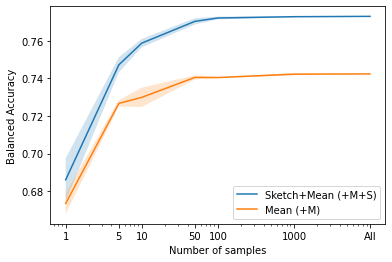

In [10]:
runs_mean = np.load('runs_mean.npy')
runs_sketch = np.load('runs_sketch.npy')
#plt.figure(figsize=(7,5))
for (runs, name) in [(runs_sketch, 'Sketch+Mean (+M+S)'), (runs_mean, 'Mean (+M)')]:
    mean = np.mean(runs, axis=0)
    std = np.std(runs, axis=0)
    x = np.array([1,5,10,50,100,1000,10000])
    plt.plot(x,mean, label=name)
    plt.fill_between(x, mean-std, mean+std, alpha=0.2)
plt.xscale('log')
x_ = list(x)
x_[-1] = 'All'
plt.xticks(x, x_)
plt.xlabel('Number of samples')
plt.ylabel('Balanced Accuracy')
plt.legend(loc='lower right', fontsize='medium')#['Sketch+Mean (+M+S)', None,'Mean (+M)',])
plt.savefig('sketch_mean_samples.png')
plt.show()